# Семинар 7: Задача Кластеризации

In [ ]:
Image(url='https://eastgate-software.com/wp-content/uploads/2023/10/Unsupervised-Learning-Clustering.png', width=800)

Кластеризация является методом обучения без учителя и распространенным методом статистического анализа данных, используемым во многих областях. В частности, используется при составлении портретов пользователей, поиска аномалий.

Исчерпывающий обзор существующих методов кластеризации представлен на [странице](https://scikit-learn.org/stable/modules/clustering.html) scikit-learn

### Imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.cm import viridis
from IPython.display import Image

from sklearn.preprocessing import StandardScaler

## К-средних

### Схема алгоритма

Алгоритм K-средних принимает на вход данные $x \in \mathcal{X}$, количество кластеров $k$, и решает следующую задачу оптимизации:
$$
\arg\min_{S}\sum_{i=1}^k\sum_{x\in S_i} \rho(x, \mu_i),
$$
Где $S$ -- разбиение данных $x$ на кластеры $\{S_1, \ldots, S_k\}$, $\mu_i$ -- центр масс кластера $S_i,\,\,$ $\rho(\cdot, \cdot)$ -- функция расстояния.

Алгоритм К-средних является наиболее известным и простым методом кластеризации, основанным на *расстоянии*. Он был разобран на семинаре 3, поэтому кратко представим схему работы:

1.   Выбирается произвольное множество точек $\mu_i$, $i=\overline{1,k}$, рассматриваемых как начальные центры кластеров: $\mu_i^{(0)} = \mu_i$.
2.   На шаге $t$
$$
x_j \in S_i ⇔ i = \arg\min_{p}\rho(x_j, \mu_p^{(t-1)}), \quad j=\overline{1,n}\,,\,\, p=\overline{1, k}
$$
3. Пересчитываем центр масс: $\mu_p^{(t)} = \frac{1}{|S_p|}\sum_{x\in S_p}x$.

4. Условие остановки: $\min\limits_{i}\rho(\mu_i^{(t-1)}, \mu_i^{(t)}) < \varepsilon$.



### Работа алгоритма

In [2]:
def create_clusters():
    np.random.seed(123)
    X1 = np.random.randn(1000,2)
    X2 = np.random.randn(1000,2) - np.array([10,1])
    X3 = np.random.randn(1000,2) - np.array([1,10])
    X = np.vstack((X1,X2,X3))
    y = np.array([1]*100 + [2]*100 + [3]*100)
    return X, y

X, y = create_clusters()

Документация [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

CPU times: user 29 ms, sys: 5.83 ms, total: 34.8 ms
Wall time: 113 ms


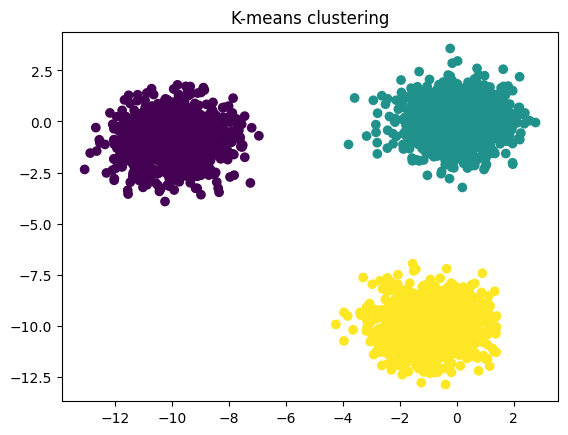

In [3]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters = 3)
%time k_means = k_means.fit(X)
clusters = k_means.predict(X)
plt.scatter(X[:,0], X[:,1], c = clusters)
plt.title('K-means clustering')
plt.show()

Посмотрим, что будет происходить, если мы не угадали с числом кластеров.

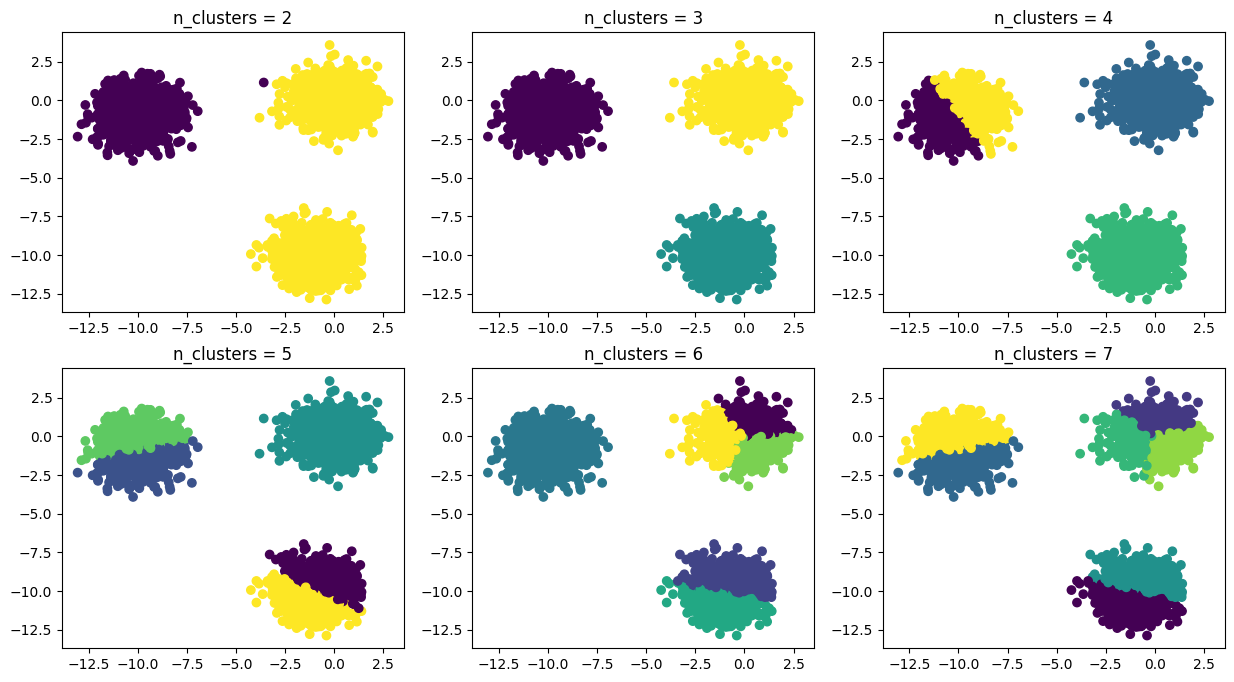

In [4]:
plt.figure(figsize= (15,8))
for n_c in range(2,8):
    k_means = KMeans(n_clusters = n_c)
    k_means = k_means.fit(X)
    clusters = k_means.predict(X)
    plt.subplot(2,3,n_c - 1)
    plt.scatter(X[:,0], X[:,1], c = clusters)
    plt.title('n_clusters = {}'.format(n_c))

plt.show()

### Summary:

**Достоинства:**
1.   Сложность $\mathcal{O}(n)$ $⇒$ хорошее масштабирование по числу примеров.

**Недостатки:**
1. Случайная инициализация центра кластеров. Результаты недетерминированные.
2. Количество кластеров является гиперпараметром алгоритма (существуют [вариации](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set) с автоматическим подбором).

**Особенности:**
1. $\rho$ по умолчанию выбирается евклидовой метрикой. Таким образом, использование К-средних оправдано в случае линейной разделимости кластеров. Такая метрика также обладает [проклятием размерности](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%BE%D0%BA%D0%BB%D1%8F%D1%82%D0%B8%D0%B5_%D1%80%D0%B0%D0%B7%D0%BC%D0%B5%D1%80%D0%BD%D0%BE%D1%81%D1%82%D0%B8).
2. Визуализация работы [K-means](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/)


## DBSCAN

DBSCAN (Density-based spatial clustering of applications with noise) -- это алгоритм, основанный на плотности: группирует вместе объекты, которые расположены близко, и помечает как выбросы те, что находятся в областях с малой плотностью.

### Схема алгоритма

Для выполнения кластеризации DBSCAN объектам (точкам) выборки присваивается 1 из 4 типов:

1.   Точка $p$ является *основной* точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем `eps` от неё.

    - Уточнение: сама точка p является собственным соседом.

2. Точка $q$ *прямо достижима* до $p$, если $\rho(q, p) < \varepsilon$ и $p$ -- основная точка. Обозначим $q \rightarrow p$.
3. Точка $q$ *достижима* до $p$, если имеется путь $p = p_1 \rightarrow \ldots \rightarrow p_n = q$. Обозначим $q \rightrightarrows p$.
4. Оставшиеся точки считаются *выбросами*

**Следствия:**
1.   Типы 1-3 являются вложенными: $p$ -- основная $⇒$ $p \rightarrow p$ $⇒$ $p \rightrightarrows p$.
2.  Тогда *выбросами* можно считать точки, *не достижимые* ни из одной основной.
3. $q \rightrightarrows p$, $\;\not\!\!\!\implies$ $p \rightrightarrows q$. Таким образом *достижимость* не является симметричным отношением.



Рассмотрим следующий пример с `min_samples=4`:

In [ ]:
Image(url='https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/DBSCAN-Illustration.svg/1420px-DBSCAN-Illustration.svg.png', width=700)

1. Красные точки являются основными: область с радиусом `eps` , окружающая эти точки, содержит по меньшей мере 4 точки (включая саму точку).
2. $B \rightrightarrows A$ и $C \rightrightarrows A$.
3. $N$ является точкой шума.



In [ ]:
# https://www.atlantbh.com/clustering-algorithms-dbscan-vs-optics/
Image(url='https://www.atlantbh.com/wp-content/uploads/2023/07/Figure-2-Demo-of-DBSCAN-algorithm.gif')

### Работа алгоритма

Документация [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

In [5]:
from sklearn.cluster import DBSCAN

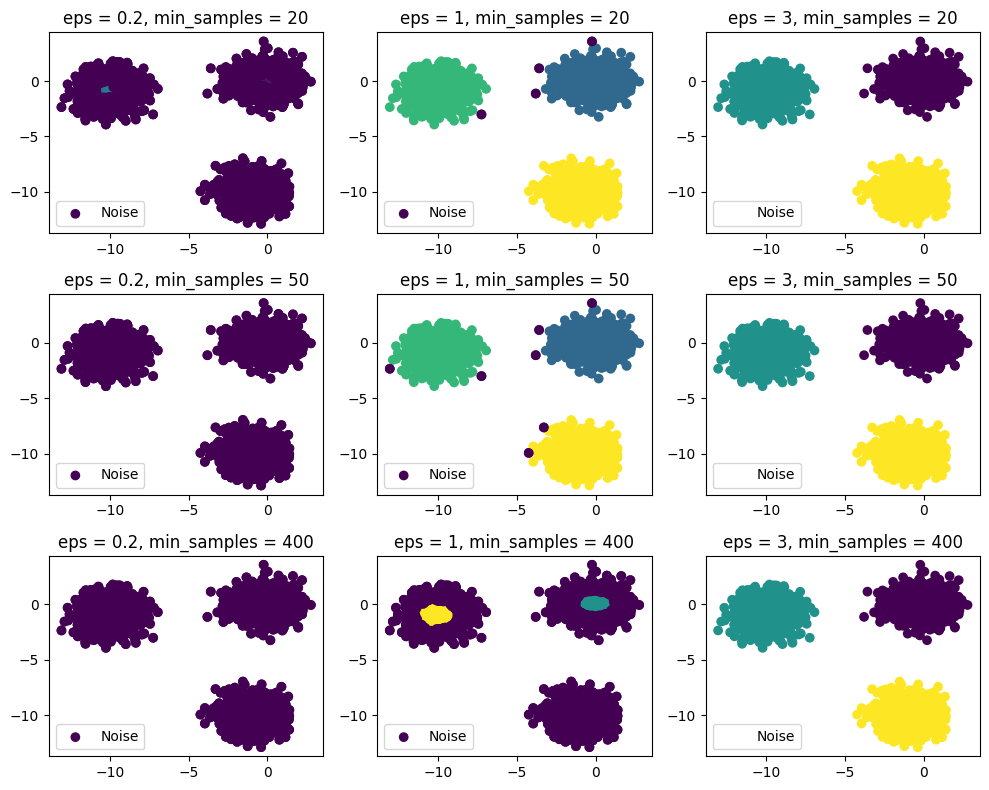

In [6]:
plt.figure(figsize=(10, 8))
i = 1
for samples in [20, 50, 400]:
    for e in [0.2, 1, 3]:
        dbscan = DBSCAN(eps=e, min_samples=samples)
        clusters = dbscan.fit_predict(X)
        plt.subplot(3, 3, i)  # 3x3 grid
        plt.scatter(X[:, 0], X[:, 1], c=clusters)
        noise = X[clusters == -1]
        plt.scatter(noise[:, 0], noise[:, 1], c=[-1 for _ in range(len(noise))], label='Noise')
        plt.title('eps = {}, min_samples = {}'.format(e, samples))
        plt.legend()
        i += 1

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

В отличие от K-средних, метод применим и для нелинейно-разделимых кластеров

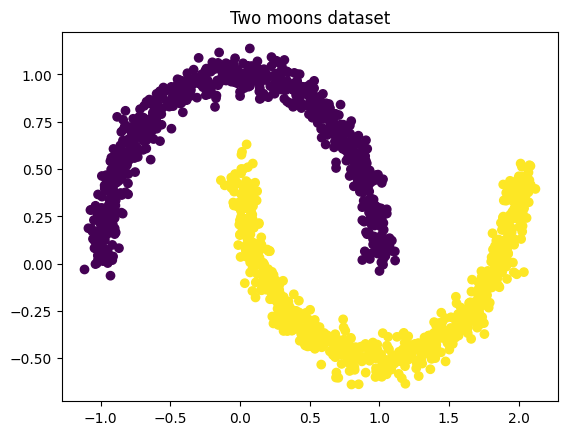

In [7]:
from sklearn import datasets

X_moon, y_moon = datasets.make_moons(n_samples=1500, noise=.05, random_state=42)
plt.scatter(X_moon[:, 0], X_moon[:, 1], c=y_moon, cmap='viridis')
plt.title(f"Two moons dataset")
plt.show()

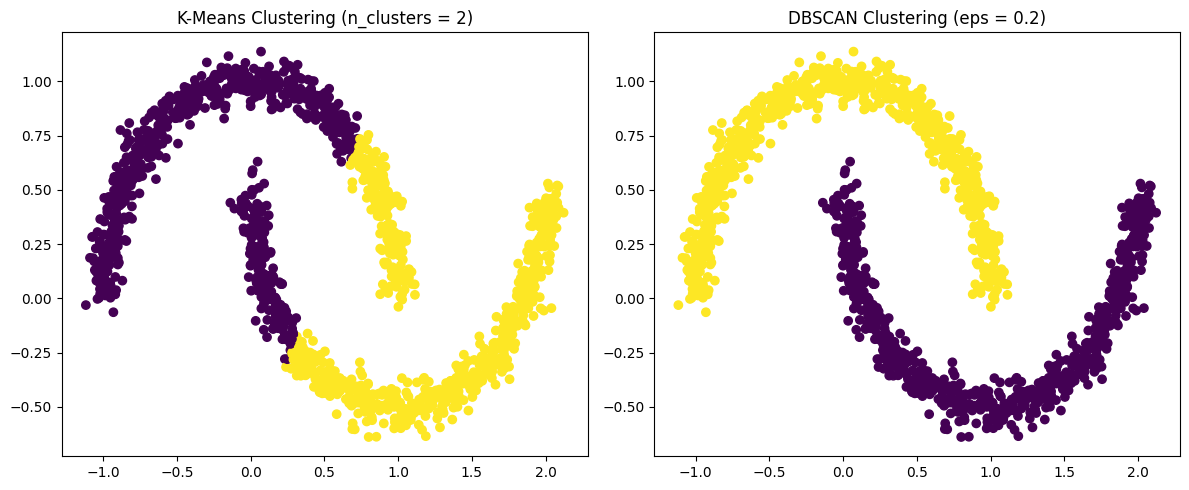

In [8]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_moon)

dbscan = DBSCAN(eps=0.2, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_moon)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_moon[:, 0], X_moon[:, 1], c=kmeans_labels, cmap='viridis')
plt.title(f"K-Means Clustering (n_clusters = 2)")
plt.subplot(1, 2, 2)
plt.scatter(X_moon[:, 0], X_moon[:, 1], c=dbscan_labels, cmap='viridis')
plt.title(f"DBSCAN Clustering (eps = 0.2)")

plt.tight_layout()
plt.show()

### Summary:

**Достоинства:**
1. В отличие от К-средних не требует указания количества кластеров $k$.
2. Может работать с нелинейно-разделимыми кластерами.
3. Имеет понятие шума и устойчив к выбросам

**Недостатки:**
1. Относительно К-средних, алгоритм вычислительно-затратнее (в худшем случае сложность алгоритма $\mathcal{O}(n^2)$).
2. Аналогично К-средним, разделение осуществляется на основе *расстояния*. Евклидова метрика обладает [проклятием размерности](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%BE%D0%BA%D0%BB%D1%8F%D1%82%D0%B8%D0%B5_%D1%80%D0%B0%D0%B7%D0%BC%D0%B5%D1%80%D0%BD%D0%BE%D1%81%D1%82%D0%B8).
3. Если данные и масштаб не вполне хорошо поняты, выбор осмысленного порога расстояния $\varepsilon$ может оказаться трудным.
4. Алгоритм плохо разделяет кластеры различной плотности.

[Визуализация](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/) DBSCAN.





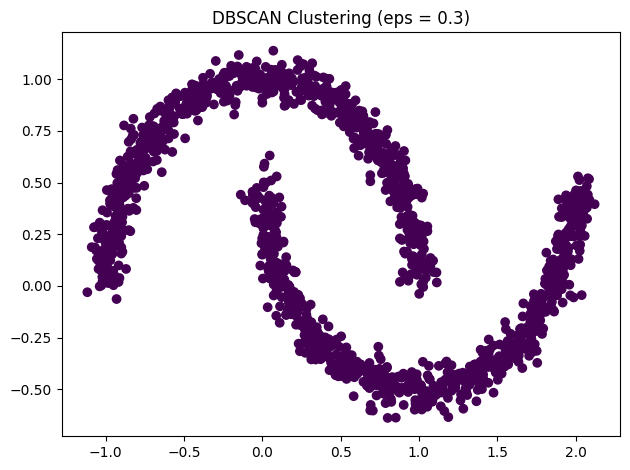

In [9]:
dbscan = DBSCAN(eps=0.3, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_moon)
plt.scatter(X_moon[:, 0], X_moon[:, 1], c=dbscan_labels, cmap='viridis')
plt.title(f"DBSCAN Clustering (eps = 0.3)")
plt.tight_layout()
plt.show()

## Иерархическая кластеризация

*Иерархическая кластеризация* — множество алгоритмов кластеризации, направленных на создание иерархии вложенных разбиений исходного множества объектов. Выделяют два класса методов иерархической кластеризации:
* *Агломеративные методы*: от меньших кластеров к большим (от листьев к стволу дерева);
* *Дивизионные методы*: от больших кластеров к меньшим (от ствола к листьям дерева).

Для однозначности, будем рассматривать *алгомеративные методы*.

### Схема метода

Алгоритмы иерархической кластеризации можно свести к следующей процедуре *слияния* кластеров:
1. В начальный момент времени каждый объект содержится в собственном кластере
2. Для слияния кластеров необходимо уметь вычислять расстояние между кластерами
    * Расстояние между одноэлементными кластерами определяется через расстояние между объектами:
$$R(\{x\}, \{y\}) =  \rho(x, y).$$
    * Расстояние между кластерами $R(U, V)$ определяется различными функциями.
3. Объединяющиеся кластеры выбираются в соответствии с наименьшим расстоянием: $U \cup \arg\min_{V}R(U, V)$.
4. Процедура повторяется до объединения всех кластеров в один.

**Функции расстояния между кластерами:**
* Метод одиночной связи:
$$ R_{\min}(U, V) = \min_{u\in U, v\in V} \rho(u, v);$$
* Метод полной связи:
$$ R_{\max}(U, V) = \max_{u\in U, v\in V} \rho(u, v);$$
* Метод средней связи:
$$ R_{\text{avg}}(U, V) = \dfrac{1}{|U|\cdot |V|}\sum_{u\in U}\sum_{v\in V}\rho(u, v);$$
* Центроидный метод:
$$ R_{\text{c}}(U, V) = \rho^2\left(\sum_{u\in U}\dfrac{u}{|U|}, \sum_{v\in V}\dfrac{v}{|V|}\right);$$
* Метод Уорда:
$$ \dfrac{|U|\cdot |V|}{|U| + |V|}\rho^2\left(\sum_{u\in U}\dfrac{u}{|U|}, \sum_{v\in V}\dfrac{v}{|V|}\right).$$



### Работа алгоритма

In [10]:
def iris_subset(num_samples=30):
    iris = datasets.load_iris()
    np.random.seed(42)  # Ensure reproducibility
    indices = np.random.choice(len(iris.data), size=num_samples, replace=False)  # Randomly pick 30 samples
    X_iris = iris.data[indices]
    y_iris = iris.target[indices]
    return iris, X_iris, y_iris

iris, X_iris, y_iris = iris_subset()

Документация [AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

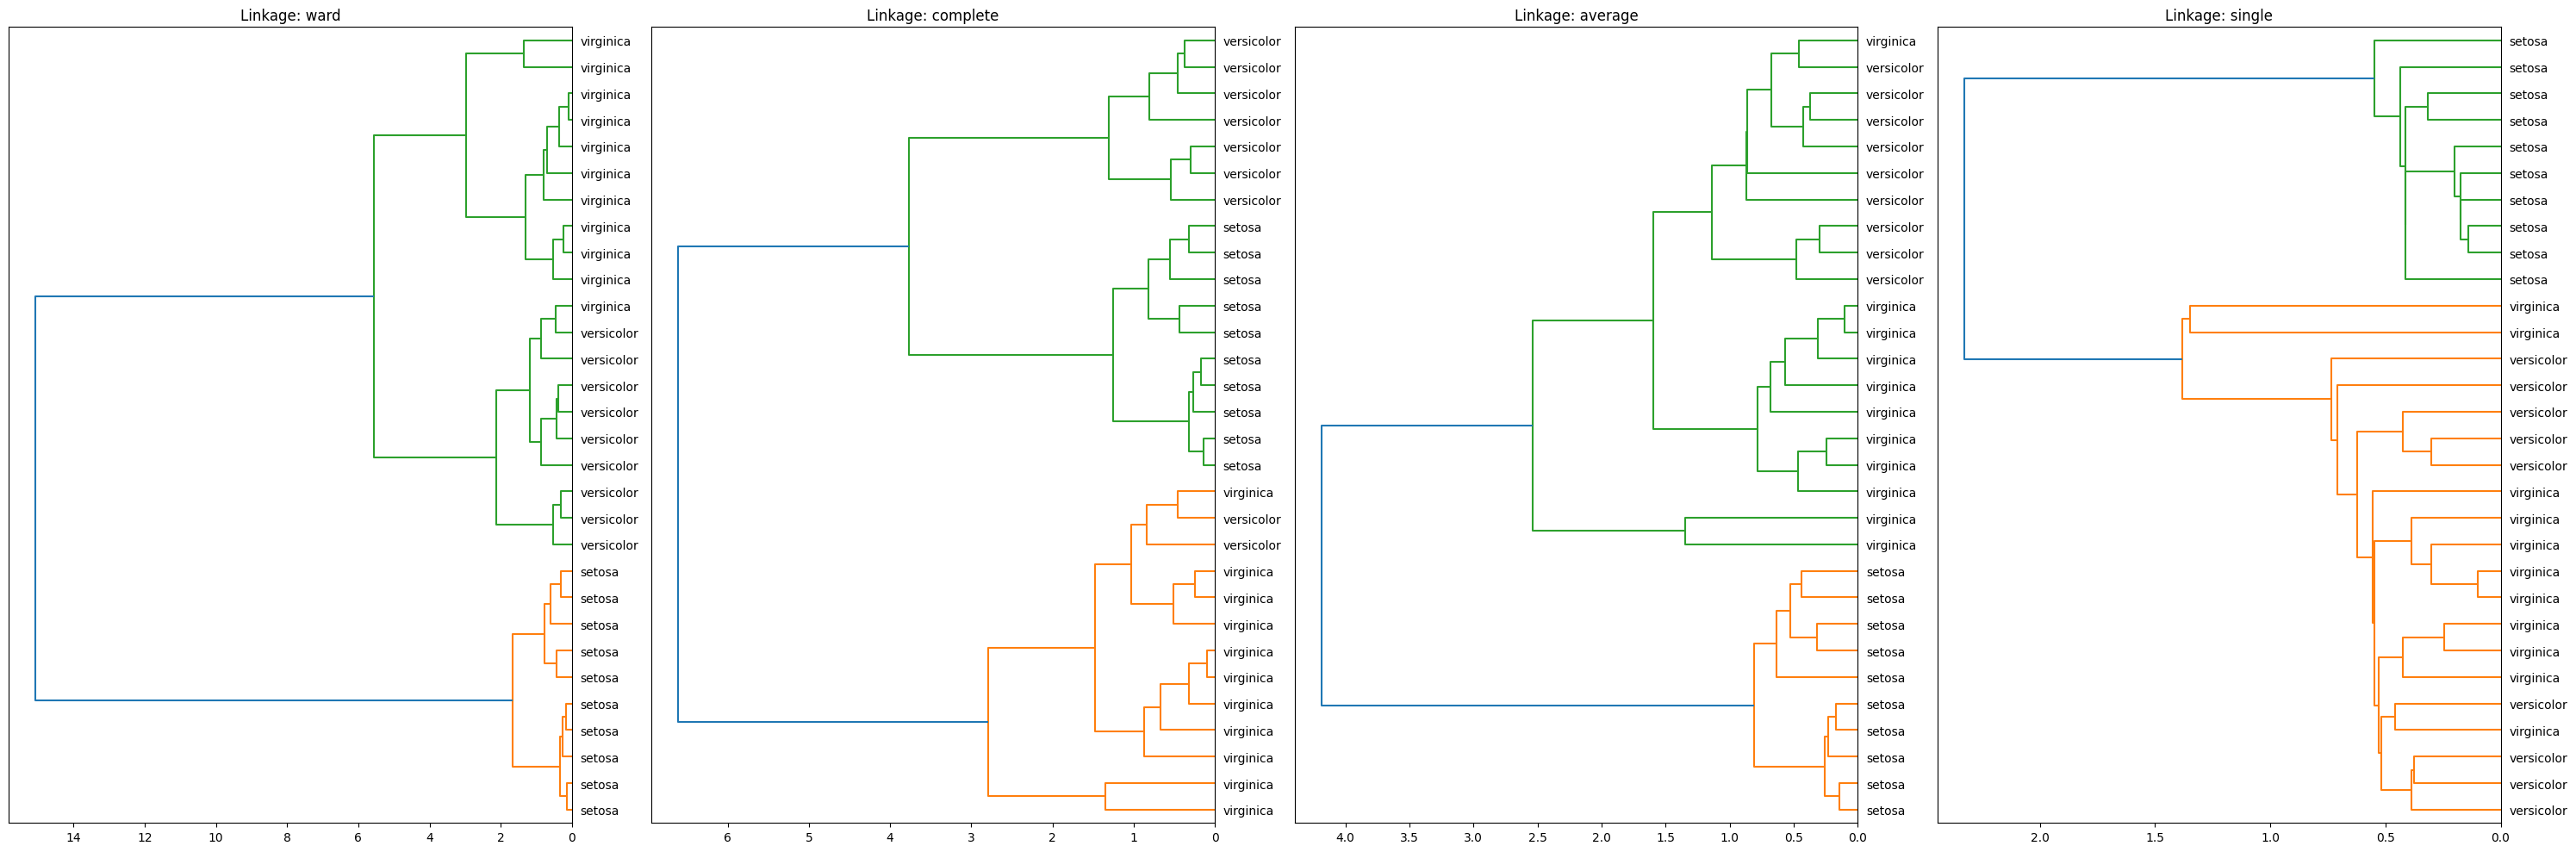

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

# Different linkage methods to compare
linkage_methods = ['ward', 'complete', 'average', 'single']

# Set up the plot
fig, axes = plt.subplots(1, len(linkage_methods), figsize=(30, 10), squeeze=False)

# Generate dendrograms for each linkage method
for i, method in enumerate(linkage_methods):
    model = AgglomerativeClustering(
        n_clusters=None,
        linkage=method,
        distance_threshold=0,  # Ensures full tree is built
        metric='euclidean',    # Use Euclidean distance (required for 'ward')
        compute_distances=True # Required to access distances
    )
    model.fit(X_iris)

    # Create linkage matrix from model attributes
    n_samples = len(model.labels_)
    counts = np.zeros(model.children_.shape[0] + n_samples)
    for j in range(n_samples):
        counts[j] = 1
    for j, merge in enumerate(model.children_):
        counts[n_samples + j] = counts[merge[0]] + counts[merge[1]]

    linkage_matrix = np.column_stack([
        model.children_,
        model.distances_,
        counts[n_samples:]
    ]).astype(float)

    # Plot the dendrogram
    ax = axes[0][i]
    dendrogram(
        linkage_matrix,
        labels=[iris.target_names[k] for k in y_iris],
        orientation='left',
        leaf_font_size=10,
        ax=ax
    )
    ax.set_title(f"Linkage: {method}")

plt.tight_layout()
plt.show()

Для определения числа кластеров находится интервал максимальной длины $|R_{t+1} - R_t|$. В качестве итоговых кластеров выдаются кластеры, полученные на шаге t.

Однако, когда число кластеров заранее неизвестно и объектов в выборке не очень много, бывает полезно изучить дендрограмму целиком.

В иерархическую кластеризацию можно добавить априорную информацию о природе данных. Она определяется через *матрицу связей*, задающих отношение между объектами выборки.

Безусловная работа алгоритма

In [ ]:
Image(url='https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Clusters.svg/1024px-Clusters.svg.png', width=400)

In [ ]:
Image(url='https://upload.wikimedia.org/wikipedia/commons/thumb/a/ad/Hierarchical_clustering_simple_diagram.svg/1280px-Hierarchical_clustering_simple_diagram.svg.png', width=600)

Матрица связей
$$
A = \begin{pmatrix}
& a & b & c & d & e & f \\
a & \cdot & \cdot& \cdot& \cdot& \cdot & \cdot\\
b & \cdot & \cdot& \cdot& \cdot& \cdot & \cdot\\
c & \cdot & \cdot& \cdot& \cdot& \cdot & \cdot\\
d & \cdot & \cdot& \cdot& \cdot& \cdot & 0.0\\
e & \cdot & \cdot& \cdot& \cdot& \cdot & 0.0\\
f & \cdot & \cdot& \cdot& 0.0& 0.0 & \cdot\\
\end{pmatrix}
$$

Работа алгоритма в случае матрицы связей $A$ и одиночной связью $R_{\min}(U, V)$:

<img src = 'https://drive.google.com/uc?id=1GCuCJZx2jk9Od2BinAkVnv_F5OYDRU7X' width = 600>

Действительно, $R_{\min}(de, f)$ не определена (все элементы внутри кластеров не связаны), а $R_{\min}(bcf, de) = \rho(b, d) < \rho(b, a) = R_{\min}(bcf, a)$, поэтому на 3-м шаге связываем $bcf$ и $de$.



### Summary:

**Достоинства:**
1. Может работать в случае нелинейной разделимости.
2. Не требует подбора гиперпараметров (в отличие от К-средних и DBSCAN).
3. Поддерживает добавление априорной информации о связи в данных.
**Недостатки:**
1. Вычислительная сложность $\mathcal{O}(n^3)$ и сложность по памяти $\Omega(n^2)$ $⇒$ трудно шкалировать даже для средних наборов данных.
**Особенности:**
1. Дендрограмма становится нечитаемой при умеренном количестве примеров. Соответственно, визуальный анализ для определения количества кластеров затруднён.



## Hirearchial + DBSCAN

### OPTICS

OPTICS (‘Ordering Points To Identify Clustering Structure’) -- модификация DBSCAN, поддерживающая кластеризацию с различными плотностями.



##### **Вопрос**

Почему DBSCAN плохо работает с разной плотностью кластеров?

Дело в том, что он содержит унифицированные гиперпараметры `eps` и `min_samples`. Эти параметры задают "масштаб" кластеризации. Если они унифицированны, масштаб для всех кластеров одинаковый.

#### Схема метода

OPTICS вводит 2 понятия:
* *Основное расстояние точки $p$:* Минимальный радиус окружности, необходимый, чтобы точка $p$ стала основной. Если этот радиус больше `eps` (т.е. точка $p$ не является основной), то основное расстояние считается неопределённым. Обозначим $\rho_{\text{core}}(p)$;

* *Достижимое растояние точки $q$ от точки $p$:* $\rho_{\text{reach}}(q, p) = \max(\rho_{\text{core}}(p), \rho(q, p))$. Если $p$ не является основной точкой, то $\rho_{\text{reach}}(q, p)$ не определена



In [ ]:
Image(url='https://www.atlantbh.com/wp-content/uploads/2023/07/Figure-3-OPTICS-core-and-reachability-distances.jpeg', width=1000, height=600)

На основе расстояний, строится график достижимости:
1. Выбираем случайную точку $p$, определяем `min_samples` соседей. Вычисляем $\rho_{\text{core}}(p)$ и $\rho_{\text{reach}}(q) = \rho_{\text{reach}}(q, p)$ всех соседей $q$. $\rho_{\text{reach}}(p)$ выставляем `undefined`;
2. Сортируем соседей $q$ по возрастанию $\rho_{\text{reach}}(q)$ и берём самого "ближайшего" соседа $q_0$;
3. Для соседа $q_0$ выполняем п.1. Если у $q_0$ и $p$ есть общий сосед $q$, то $\rho_{\text{reach}}(q) = \min\{\rho_{\text{reach}}(q, p), \rho_{\text{reach}}(q, q_0)\}$.
4. Повторяем п.2 и выбираем следующую точку $q_1$.



<img src = 'https://drive.google.com/uc?id=1GvlzBXJr1MO4nl9I6yzb8rd-spyIu-_S' width = 800>

<img src = 'https://drive.google.com/uc?id=1LqTfhuRpf07c5b0ksdyDl0pVNUgg1rK8' width = 800>

<img src = 'https://drive.google.com/uc?id=1jAb535-RjPH5rwwdwSyJoHQWlClwjcq_' width = 800>

<img src = 'https://drive.google.com/uc?id=1Z7JOXVZjp34RdFx8RA_uRTemIbgVL0MQ' width = 800>

In [ ]:
Image(url='https://www.atlantbh.com/wp-content/uploads/2023/07/Figure-5-Reachability-plot-768x432.jpeg', width=800)

График достижимости является *дендрограммой*. С помощью него можно получить *иерархическую* структуру кластеров. Анализ графика позволяет добиться учёта различной плотности кластеров.

In [ ]:
Image(url='https://www.atlantbh.com/wp-content/uploads/2023/07/Figure-6-Extracting-clusters-using-different-methods-768x432.jpeg', width=800)

In [ ]:
Image(url='https://upload.wikimedia.org/wikipedia/commons/thumb/f/f9/OPTICS.svg/712px-OPTICS.svg.png', width=800)

#### Работа алгоритма

Документация [OPTICS](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html)

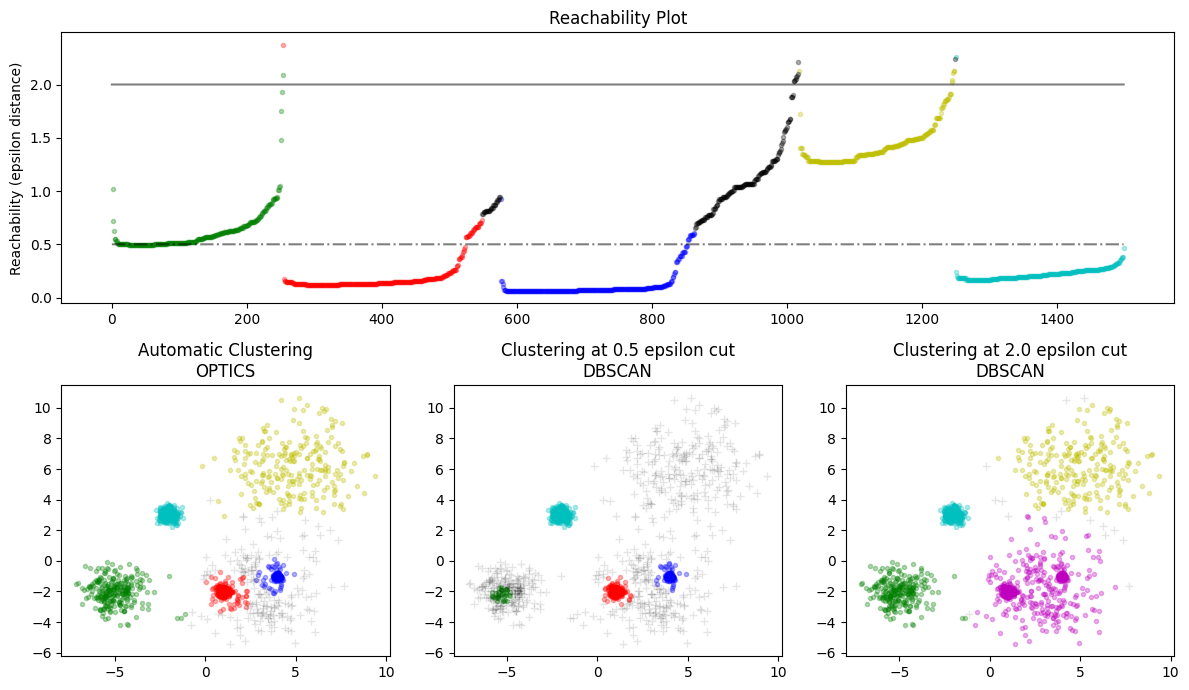

In [ ]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.gridspec as gridspec

from sklearn.cluster import OPTICS, cluster_optics_dbscan

# Generate sample data

np.random.seed(0)
n_points_per_cluster = 250

C1 = [-5, -2] + 0.8 * np.random.randn(n_points_per_cluster, 2)
C2 = [4, -1] + 0.1 * np.random.randn(n_points_per_cluster, 2)
C3 = [1, -2] + 0.2 * np.random.randn(n_points_per_cluster, 2)
C4 = [-2, 3] + 0.3 * np.random.randn(n_points_per_cluster, 2)
C5 = [3, -2] + 1.6 * np.random.randn(n_points_per_cluster, 2)
C6 = [5, 6] + 2 * np.random.randn(n_points_per_cluster, 2)
X = np.vstack((C1, C2, C3, C4, C5, C6))

clust = OPTICS(min_samples=50, xi=0.05, min_cluster_size=0.05)

# Run the fit
clust.fit(X)

labels_050 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=0.5,
)
labels_200 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=2,
)

space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(12, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")

# OPTICS
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = X[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title("Automatic Clustering\nOPTICS")

# DBSCAN at 0.5
colors = ["g.", "r.", "b.", "c."]
for klass, color in enumerate(colors):
    Xk = X[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax3.plot(X[labels_050 == -1, 0], X[labels_050 == -1, 1], "k+", alpha=0.1)
ax3.set_title("Clustering at 0.5 epsilon cut\nDBSCAN")

# DBSCAN at 2.
colors = ["g.", "m.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = X[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(X[labels_200 == -1, 0], X[labels_200 == -1, 1], "k+", alpha=0.1)
ax4.set_title("Clustering at 2.0 epsilon cut\nDBSCAN")

plt.tight_layout()
plt.show()

### HDBSCAN




Еще 1 метод, развивающий DBSCAN, направленный на более стабильную работу при варьировании гиперпараметров.



1. [How HDBSCAN Works](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html)
2. [HDBSCAN demo](https://scikit-learn.org/stable/auto_examples/cluster/plot_hdbscan.html#sphx-glr-auto-examples-cluster-plot-hdbscan-py)

### Summary:

**Достоинства:**
1. OPTICS позволяет обнаруживать кластеры с переменной плотностью.
2. HDBSCAN позволяет автоматически определять оптимальное число кластеров за счёт построения иерархической структуры. Он минимизирует влияние параметров, заменяя жесткий выбор ε на более интуитивные параметры (например, минимальный размер кластера).

**Недостатки:**
1. OPTICS для выделения кластеров требует дополнительной интерпретации reachability-диаграммы, что может осложнить автоматизацию процесса. Метод чувствительнее к настройке гиперпараметров.
2. HDBSCAN наследует проблемы Иерархической кластеризации -- вычислительная сложность и визуальная интерпретация.

## К-средних + MNIST

100%|██████████| 9.91M/9.91M [00:00<00:00, 59.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.69MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.17MB/s]


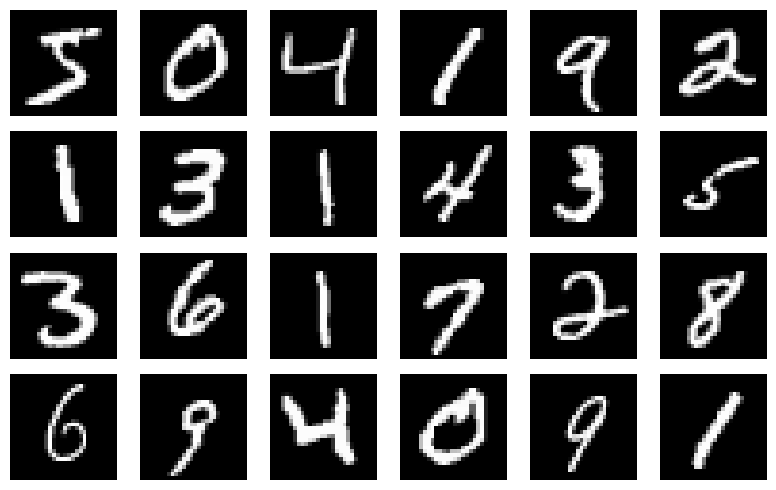

In [12]:
from torchvision import datasets as tdatasets
from torchvision import transforms

def get_mnist_data():
    mnist_train = tdatasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

    X_train = mnist_train.data.view(-1, 28*28).numpy()
    y_train = mnist_train.targets.numpy().astype(int)
    X_train = X_train / 255.

    batch = X_train[:24]
    fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(8, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(batch[i].reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    return X_train, y_train

X_mnist, y_mnist = get_mnist_data()

In [ ]:
n_clusters = 10  # Since MNIST has 10 digits (0-9)
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(X_mnist)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
def map_clusters_to_labels(y_true, y_pred, n_clusters):
    mapping = {}
    for cluster in range(n_clusters):
        mask = y_pred == cluster
        labels, counts = np.unique(y_true[mask], return_counts=True)
        mapping[cluster] = labels[np.argmax(counts)]
    return mapping

cluster_to_label = map_clusters_to_labels(y_mnist, kmeans.labels_, n_clusters)

y_pred_labels = np.array([cluster_to_label[cluster] for cluster in kmeans.labels_])

print("\nClassification Report:")
print(classification_report(y_mnist, y_pred_labels))

## Метрики качества кластеризации

Подробный обзор на [вики](https://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%B2_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B5_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8).






### Теорема невозможности Клейнберга

[**Теорема невозможности Клейнберга:**](https://www.cs.cornell.edu/home/kleinber/nips15.pdf) Для множества объектов, состоящего из двух и более элементов, не существует алгоритма кластеризации, который был бы одновременно масштабно-инвариантным, согласованным и полным.

Давайте выделим следующие свойства алгоритмов кластеризации в качестве аксиом:

1. Алгоритм $a$ является **масштабно инвариантным**,  если для любой функции расстояния $\rho$ и любой константы $\alpha > 0$ результаты $a$, $a_{\rho}$, $a_{\alpha\rho}$ совпадают;
2. Определим множество объектов $X$ и множество всех возможных [разбиений](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D0%B7%D0%B1%D0%B8%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BC%D0%BD%D0%BE%D0%B6%D0%B5%D1%81%D1%82%D0%B2%D0%B0) $\cup_{c \in C}U_c$:
    * Например
$$X = \{1, 2, 3\} → \cup_{c \in C}U_c = \{\{1, 2, 3\}, \{\{1\}, \{2, 3\}\}, \{\{2\}, \{1, 3\}\}, \{\{3\}, \{2, 1\}\}, \{\{1\}, \{2\}, \{3\}\}\};$$
    * Алгоритм $a$ называется **полным**, если он может разбить $X$ на любой $U_c$ в зависимости от функции расстояния $\rho$.
3. Алгоритм $a$ называется **согласованным**, если результат кластеризации не изменяется после допустимого преобразования функции расстояния.
    * Функция расстояния $\rho′$ является **допустимым преобразованием** функции расстояния $\rho$, если
        1. $\rho′(x_i, x_j) \leqslant \rho(x_i, x_j)$, если $x_i, x_j$ лежат в одном и том же кластере.
        2. $\rho′(x_i, x_j) \geqslant \rho(x_i, x_j)$, если $x_i, x_j$ лежат в разных кластерах.


[**Теорема невозможности Клейнберга:**](https://www.cs.cornell.edu/home/kleinber/nips15.pdf) Для множества объектов, состоящего из двух и более элементов, не существует алгоритма кластеризации, который был бы одновременно масштабно-инвариантным, согласованным и полным.

Клейнберг также [показал](https://www.cs.cornell.edu/home/kleinber/nips15.pdf), что иерархический метод кластеризации по методу одиночной связи $R_{\min}(U, V) = \min_{u\in U, v\in V} \rho(u, v)$ удовлетворяет любым 2-м из 3-х аксиом.

### Оценка качества кластеризации

Проблема *оценки качества* в задаче кластеризации **трудноразрешима**, как минимум, по двум причинам:
* Теорема невозможности Клейнберга — не существует оптимального алгоритма кластеризации.
* Априорная информация о количестве кластеров не всегда доступна. Многие алгоритмы кластеризации не способны определить настоящее количество кластеров в данных. Чаще всего количество кластеров подается на вход алгоритма и подбирается несколькими запусками алгоритма.

Запишем реальные классы $X = \{X_1, X_2, \dots, X_r\}$ и выделенные кластеры $Y = \{Y_1, Y_2, \dots, Y_s\}$. Определим *таблицу сопряжённости*

$$
\begin{array}{c|cccc|c}
    X \setminus Y & Y_1 & Y_2 & \cdots & Y_s & \text{sums} \\
    \hline
    X_1 & n_{11} & n_{12} & \cdots & n_{1s} & a_1 \\
    X_2 & n_{21} & n_{22} & \cdots & n_{2s} & a_2 \\
    \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
    X_r & n_{r1} & n_{r2} & \cdots & n_{rs} & a_r \\
    \hline
    \text{sums} & b_1 & b_2 & \cdots & b_s &
\end{array}
$$

По аналогии с матрицей смежности определим:
* Элементы принадлежат одному кластеру и одному классу — $TP$
* Элементы принадлежат одному кластеру, но разным классам — $FP$
* Элементы принадлежат разным кластерам, но одному классу — $FN$
* Элементы принадлежат разным кластерам и разным классам — $TN$

*Индекс Rand* определяет степень сходства классов и кластеров
$$
RI = \dfrac{TP + TN}{TP + FP + FN + TN} \in [0, 1]
$$
*Индекс Adjusted Rand* вводит поправку на случай большого количества кластеров.
$$
\text{ARI} = \frac{
    \overbrace{\sum_{ij} \binom{n_{ij}}{2}}^{Index} -
    \overbrace{\left[ \sum_i \binom{a_i}{2} \sum_j \binom{b_j}{2} \right]}^{Expected Index} / \binom{n}{2}
}{
    \frac{1}{2} \underbrace{\left[
        \sum_i \binom{a_i}{2} + \sum_j \binom{b_j}{2}
    \right]}_{Max Index} -
    \underbrace{\left[ \sum_i \binom{a_i}{2} \sum_j \binom{b_j}{2} \right]}_{Expected Index} / \binom{n}{2}
} \in [-1, 1]
$$

Основная интуиция состоит в том, что элементы из $TN$ не обязательно являются верными. Например, пара $(x_1, x_3) \in (X_1, X_3)$, кластеризованная в пару $(y_2, y_4) \in (Y_2, Y_4)$ будет $TN$, но не отображает корректную кластеризацию.

Более можно почитать [тут](https://davetang.org/muse/2017/09/21/adjusted-rand-index/)

In [ ]:
from sklearn.metrics import rand_score, adjusted_rand_score

In [ ]:
%%time
ri_score = rand_score(y, kmeans.labels_)
ari_score = adjusted_rand_score(y, kmeans.labels_)
print(f"Rand Index (RI): {ri_score:.4f}")
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")

Rand Index (RI): 0.8818
Adjusted Rand Index (ARI): 0.3652
CPU times: user 19.3 ms, sys: 0 ns, total: 19.3 ms
Wall time: 18.5 ms


##### **Что делать в случае, если данные являются неразмеченными?**

Метрики, отражающие качество классификации без учёта априорной информации о разметке называются *внутренними* (анализируют внутреннюю структуру кластеров)

* *Компактность/Отделимость* кластеров оценивают расстояние объектов внутри/вне кластеров. Чем ближе/дальше объекты, тем лучше разделение:
$$
WSS = \sum_{i=1}^s\sum_{j=1}^{|Y_j|}\|x_{ij} - \bar{x_j}\|^2 \rightarrow \min, \quad BSS = n\cdot\sum_{j=1}^s\|\bar{x}_j - \bar{x}\| \rightarrow \max
$$
* *Индекс Данна* показывает отношение отделимости кластеров к их компактности:
$$
\delta = \dfrac{\min_{Y_i, Y_j}\{BSS\}}{\max_Y\{WSS\}} \rightarrow \max
$$
* *Силуэт* показывает, насколько объект похож на свой кластер по сравнению с другими кластерами.
$$
Sil = \dfrac{1}{n}\sum_{i=1}^s\sum_{x_j \in Y_i}\dfrac{bss(x_j, Y_i) - wss(x_j, Y_i)}{\max\{bss(x_j, Y_i), wss(x_j, Y_i)\}} \in [-1, 1] \rightarrow \max
$$
    * $Sil = 1$ -- идеальное разделение
    * $Sil = -1$ -- отсутствие разделения: точки кластера могут быть ближе к другому кластеру, чем к центру.

$$
bss(x_j, Y_i) = \min_{Y_k \in Y \backslash Y_i}\left\{\dfrac{1}{|Y_k|}\sum_{x_i \in Y_k}\|x_j - x_i\|\right\},
$$
Cреднее расстояние от $x_j \in Y_i$ до ближайшего кластера $Y_k$ (отделимость)
$$
wss(x_j, Y_i) = \dfrac{1}{|Y_i|}\sum_{x_i \in Y_i}\|x_j - x_i\|,
$$
Cреднее расстояние внутри $Y_i$ относительно $x_j$ (компактность)

* *Индекс Девиса-Болдуина* оценивает, насколько кластеры отличаются друг от друга с учётом их компактности
$$
DB = \dfrac{1}{s}\sum_{i=1}^s\max_{j\neq i}\left\{\dfrac{wss(\bar{x}_i, Y_i) + wss(\bar{x}_j, Y_j)}{\|\bar{x}_i - \bar{x}_j\|}\right\} \geqslant 0 \rightarrow \min.
$$

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [ ]:
%%time
silhouette_avg = silhouette_score(X, kmeans.labels_)
db_avg = davies_bouldin_score(X, kmeans.labels_)

print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Davies Bouldin Score: {db_avg:.4f}")

Silhouette Score: 0.0587
Davies Bouldin Score: 2.7760
CPU times: user 7min 33s, sys: 15.6 s, total: 7min 48s
Wall time: 4min 57s


##### **Какая сложность описанных метрик?**

* Силуэт -- $\mathcal{O}(n^2d)$, где $n$ -- число примеров, $d$ -- размерность $x$
* Индекс Девиса-Болдуина -- $\mathcal{O}(nd + s^2d) \overset{s \ll n}{\approx} \mathcal{O}(nd)$, где $s$ -- количество кластеров

In [ ]:
%%time
db_avg = davies_bouldin_score(X, kmeans.labels_)
print(f"Davies Bouldin Score: {db_avg:.4f}")

Davies Bouldin Score: 3.9399
CPU times: user 1.34 s, sys: 707 µs, total: 1.34 s
Wall time: 1.87 s


## Понижение размерности

Практически все описанные методы трудно масштабируются на данные, обладающие высокой размерностью. Вместе с этим, практически все современные наборы содержат большое количество признаков. В связи с этим, кластеризацию объектов можно осуществить с помощью *понижения размерности*. Полученные информативные признаки отображаются на плоскости и строится визуальная кластеризация. Имея априорную информацию об объектах, мы можем интерпретировать результаты кластеризации. Такой информацией может быть разметка, или выдвигаемая гипотеза, например, зависимость признаковых описаний (категория людей $A$ в возрастном диапазоне $D$ чаще страдает от $B$).

### PCA




#### Схема работы

*Метод Главных Компонент (Principal Component Analysis, PCA)* является классическим методом понижения размерности. Схематично опишем принцип работы:

1. Обозначим $X$ матрица объекты-признаки, с нулевым средним каждого признака, а $w$ некоторый единичный вектор. Тогда $Xw$ задает величину проекций всех объектов на этот вектор. Разложение на главные компоненты состоит в поиске вектора, проекция которого описывает наибольшую дисперсию:
$$
\max_{w: \|w\|=1}\|Xw\|^2
$$
2. Можно показать, что подходящий вектор равен равен собственному вектору матрицы $XX^\top$, соответствующий максимальному с.з.
3. После нахождения $w$, пространство проецируется на ортогональное дополнение и процесс повторяется.

#### Linear PCA

In [ ]:
from sklearn.decomposition import PCA, KernelPCA

In [ ]:
pca = PCA(n_components=2)
pca_X = pca.fit_transform(X)
pca.explained_variance_ratio_.sum()

np.float64(0.16901560509373442)

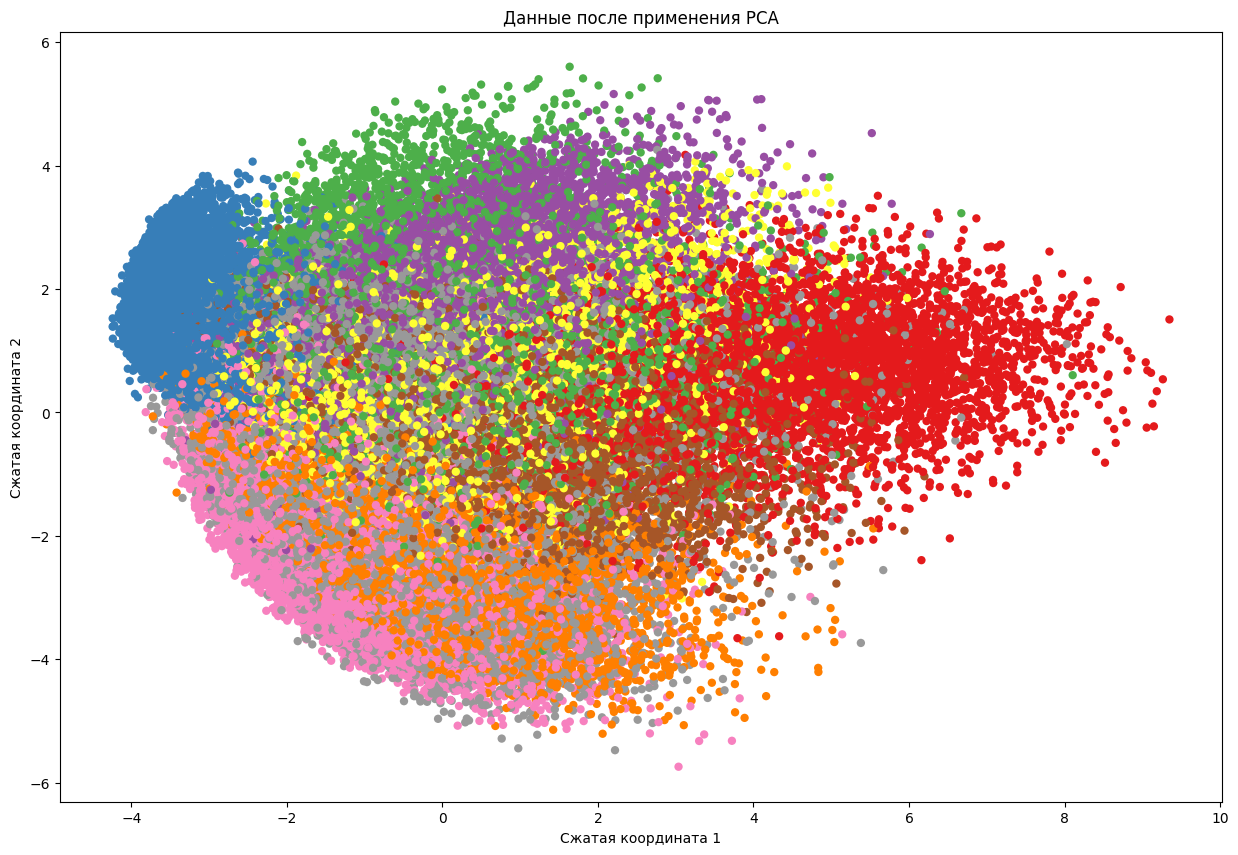

In [ ]:
plt.figure(figsize=(15, 10))
plt.scatter(pca_X[:, 0], pca_X[:, 1], c=y, linewidths=0, cmap='Set1')

plt.title('Данные после применения PCA')
plt.xlabel('Сжатая координата 1')
plt.ylabel('Сжатая координата 2')

plt.show()

**Вывод:** Прямое сжатие признаков изображения MNIST с помощью PCA с целью их отображения на плоскости не даёт визуальной кластеризации. Доля объяснимой дисперсии 2 главными компонентами < 17%.

In [ ]:
pca = PCA(n_components=0.95)
pca_X = pca.fit_transform(X)
pca_X.shape[1]

154

#### Схема Kernel PCA

Когда количество примеров в выборке сильно больше их размерности $N > d$, зачастую, она является линейно-неразделимой. Переход в более высокоразмерное пространтсво $\psi: \mathbb{R}^d \rightarrow \mathbb{R}^N$ позволяет построить разделяющую гиперплоскость для произвольного (не больше $N$) числа кластеров

In [ ]:
Image(url='https://shorturl.at/zE135', width=600)

"Платой" за линейную разделимость является размерность получаемых примеров $\psi(x) \in \mathbb{R}^N$, $N > d$.

["Ядерный трюк" (англ. Kernel Trick) ](https://en.wikipedia.org/wiki/Kernel_method#Mathematics:_the_kernel_trick) позволяет обойти ограничение размерности. Он пременим в том случае, когда метод зависит только от попарных произведений $\langle x_i, x_j \rangle$, а не отдельных значений $x_i$ и $x_j$.

Вместо определения $\psi: \mathbb{R}^d \rightarrow \mathbb{R}^N$, можно определить функцию **ядра**
$$
\mathcal{K}: \mathcal{X}\times\mathcal{X} \rightarrow \mathbb{R}, \quad \mathcal{K}(x_i, x_j) = \langle \psi(x_i), \psi(x_j) \rangle
$$
и матрицу ковариации в пространстве признаков
$$
K' = K - \mathbf{1_N}K - K\mathbf{1_N} + \mathbf{1_N}K\mathbf{1_N}, \quad K = \|\mathcal{K}(x_i, x_j)\|_{i, j}^N,\,\,\, \mathbf{1_N} \equiv \|1/N\|_{i, j}^N.
$$

Примеры распространённых ядерных функций:
* Константа $ \mathcal{K}_{C}(x,y) = C$;
* Линейное $\mathcal{K}_{L}(x,y) =  x^\top y$;
* Полиномиальное $\mathcal{K}_{d, c}(x,y) = (x^\top y + c)^d$;
* Радиально-Базисная Функция (РБФ) $\mathcal{K}_\gamma(x, y) = \exp\left\{\gamma\|x-y\|^2\right\}$;



#### Работа Kernel PCA

In [ ]:
from sklearn.decomposition import KernelPCA

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_moon)
kmeans_pca = KMeans(n_clusters=2, random_state=42)
clusters_pca = kmeans_pca.fit_predict(X_pca)

In [ ]:
krbfpca = KernelPCA(n_components=2, kernel='rbf')
X_krbfpca = krbfpca.fit_transform(X_moon)
kmeans_krbfpca = KMeans(n_clusters=2, random_state=42)
clusters_krbfpca = kmeans_krbfpca.fit_predict(X_krbfpca)

In [ ]:
kppca = KernelPCA(n_components=2, kernel='poly')
X_kppca = kppca.fit_transform(X_moon)
kmeans_kppca = KMeans(n_clusters=2, random_state=42)
clusters_kppca = kmeans_kppca.fit_predict(X_kppca)

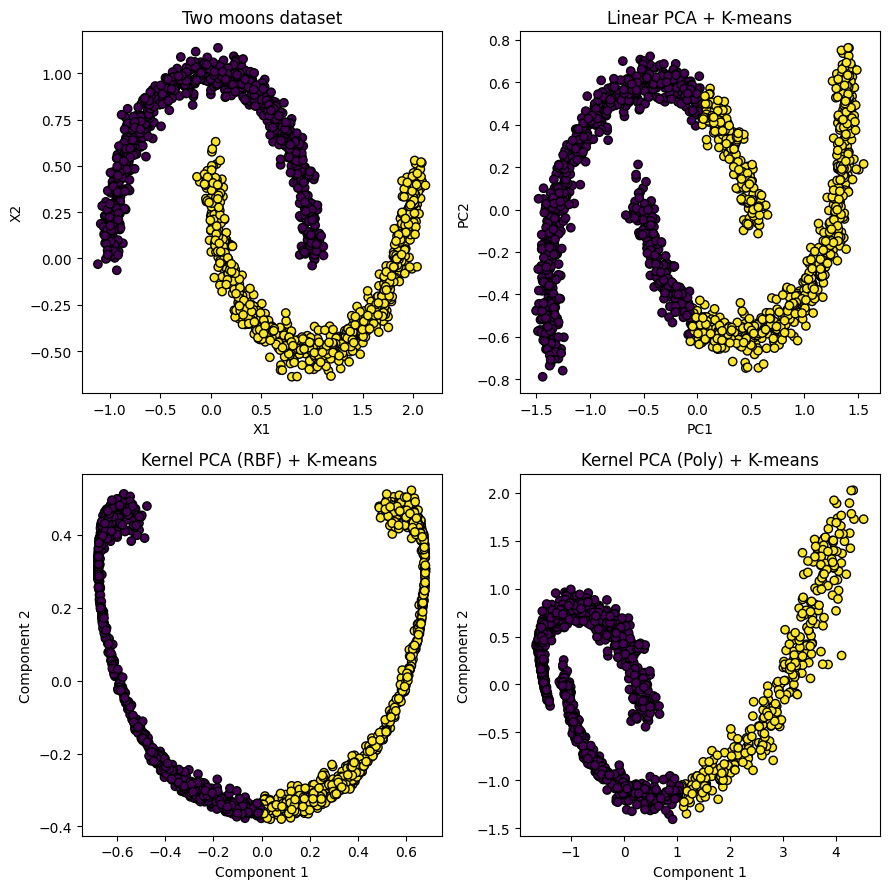

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(9, 9))

ax[0][0].scatter(X_moon[:, 0], X_moon[:, 1], c=y_moon, cmap='viridis', edgecolor='k')
ax[0][0].set_title("Two moons dataset")
ax[0][0].set_xlabel("X1")
ax[0][0].set_ylabel("X2")

ax[0][1].scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_pca, cmap='viridis', edgecolor='k')
ax[0][1].set_title("Linear PCA + K-means")
ax[0][1].set_xlabel("PC1")
ax[0][1].set_ylabel("PC2")

ax[1][0].scatter(X_krbfpca[:, 0], X_krbfpca[:, 1], c=clusters_krbfpca, cmap='viridis', edgecolor='k')
ax[1][0].set_title("Kernel PCA (RBF) + K-means ")
ax[1][0].set_xlabel("Component 1")
ax[1][0].set_ylabel("Component 2")

ax[1][1].scatter(X_kppca[:, 0], X_kppca[:, 1], c=clusters_kppca, cmap='viridis', edgecolor='k')
ax[1][1].set_title("Kernel PCA (Poly) + K-means")
ax[1][1].set_xlabel("Component 1")
ax[1][1].set_ylabel("Component 2")

plt.tight_layout()
plt.show()

### t-SNE


t-Distributed Stochastic Neighbor Embedding (t-SNE) -- [Оффициальная страница автора](https://lvdmaaten.github.io/tsne/)

Реализация в sklearn: [sklearn.manifold.TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

#### SNE

Имеем выборку $x_1, \ldots, x_n \in \mathbb{R}^D$. Хотим получить выборку $y_1, \ldots, y_n \in \mathbb{R}^d$ меньшей размерности $d < D$ с сохранением кластерной структуры.

1. Зафиксируем $x_i$ и опредлим близость до каждого из объектов $\|x_i - x_j\|^2$.
2. Чем ближе $x_j$ к $x_i$, тем более вероятно мы выберем его соседом. Можно определить соответствующее распределение
$$
p_{j | i} = \dfrac{\exp\{-\|x_i - x_j\|^2/2\sigma_i^2\}}{\sum_{k\neq i}\exp\{-\|x_i - x_k\|^2/2\sigma_i^2\}},
$$
на которое можно смотреть по аналогии SoftMax с температурой $T = 1/2\sigma_i^2$ или "вероятность выбрать $x_j$ в качестве соседа $x_i$ пропорционально $\mathcal{N}(x_i, \sigma_i^2)$ в точке $x_j$"


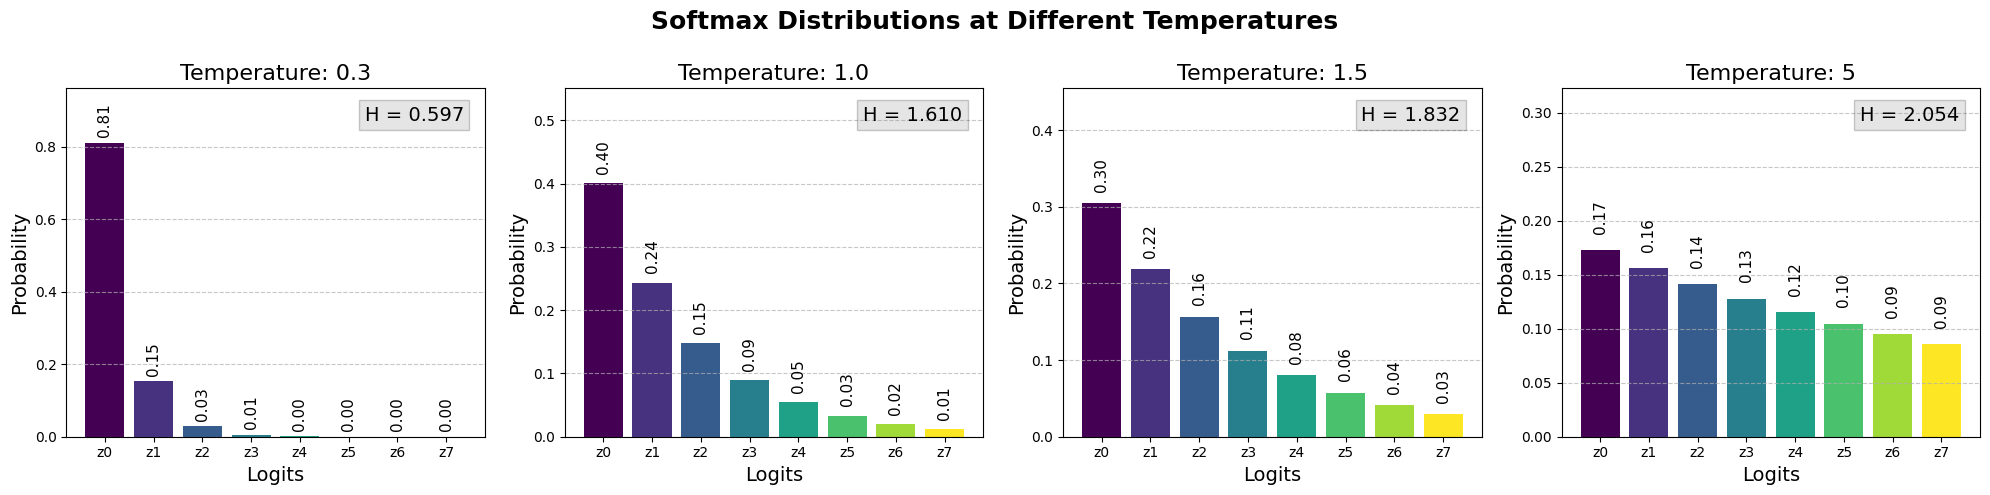

In [ ]:
def softmax(x, temperature=1.0):
    x_scaled = x / temperature
    # For numerical stability
    e_x = np.exp(x_scaled - np.max(x_scaled))
    return e_x / e_x.sum()


def softmax_temp_plot():
    plt.figure(figsize=(20, 5))
    plt.suptitle('Softmax Distributions at Different Temperatures', fontsize=18, fontweight='bold')

    np.random.seed(42)
    z = np.array([2.0, 1.5, 1.0, 0.5, 0.0, -0.5, -1.0, -1.5])

    temperatures = [0.3, 1.0, 1.5, 5]

    colors = viridis(np.linspace(0, 1, len(z)))

    for i, temp in enumerate(temperatures):
        ax = plt.subplot(1, 4, i+1)

        probs = softmax(z, temp)
        entropy = -np.sum(probs * np.log(probs + 1e-10))

        bars = ax.bar(range(len(z)), probs, color=colors)

        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.015,
                    f'{height:.2f}', ha='center', va='bottom',
                    fontsize=11, rotation=90)

        ax.text(0.95, 0.95, f'H = {entropy:.3f}',
                transform=ax.transAxes, ha='right', va='top', bbox=dict(facecolor='gray', alpha=0.2), fontsize=14)

        ax.set_ylim(0, max(probs)+0.15)
        ax.set_xticks(range(len(z)))
        ax.set_xticklabels([f'z{i}' for i in range(len(z))])
        ax.set_xlabel('Logits', fontsize=14)
        ax.set_ylabel('Probability', fontsize=14)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.set_title(f'Temperature: {temp}', fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

softmax_temp_plot()

3. Энтропия распределения $P_i = (p_{1 | i}, \ldots p_{n | i})$
$$
H(\sigma_i) = -\sum_{j = 1}^n p_{j|i}\log_2 p_{j|i}.
$$
В этом смысле $\sigma_i$ связана с количество "соседей" $x_i$: малые $\sigma_i$ -- низкая энтропия, ярко выделено мало примеров -- мало соседей; большие $\sigma_i$ -- вероятности "сглаживаются" -- больше соседей. Более явную (целочисленную) связь даёт перплексия $Perp(P_i(\sigma_i)) = 2^{H(P_i(\sigma_i))}$

4. Аналогично можно определить распределение над $y_1, \ldots y_n$ для $\sigma^2_i = 1/2$
$$
q_{j | i} = \dfrac{\exp\{-\|y_i - y_j\|^2\}}{\sum_{k\neq i}\exp\{-\|y_i - y_k\|^2\}}.
$$

##### **Как поставить оптимизационную задачу?**

5. Ограничением понижения размерности является "сохранение кластерной структуры". В описанных терминах это означает похожесть распределений $P_i$ и $Q_i$.
$$
\mathcal{L} = \sum_{i=1}^n KL(P_i, Q_i) = \sum_{i=1}^n\sum_{j=1}^n p_{j|i}\log\frac{p_{j|i}}{q_{j|i}} \rightarrow \min_{y_1, \ldots y_n}
$$

Соответствующий градиент в точке $y_i$
$$
\dfrac{\partial\mathcal{L}}{\partial y_i} = 2\sum_{i=1}^n(p_{j|i} - q_{j|i} + p_{i|j} - q_{i|j})(y_i - y_j)
$$
* Антиградиент задаёт направление $(y_j - y_i)$, вдоль которого мы обновляем стартовую точку $y_i$. Перенос масштабируется на $(p_{j|i} - q_{j|i} + p_{i|j} - q_{i|j})$.
* Если $p > q$, то в исходном пространстве $x_j$ ближе к $x_i$ $\Rightarrow$ масштаб уменьшается.



#### Проблема скученности

Подробнее [тут](https://neerc.ifmo.ru/wiki/index.php?title=%D0%A1%D1%82%D0%BE%D1%85%D0%B0%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%B2%D0%BB%D0%BE%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5_%D1%81%D0%BE%D1%81%D0%B5%D0%B4%D0%B5%D0%B9_%D1%81_t-%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5%D0%BC#.D0.9F.D1.80.D0.BE.D0.B1.D0.BB.D0.B5.D0.BC.D0.B0_.D1.81.D0.BA.D1.83.D1.87.D0.B5.D0.BD.D0.BD.D0.BE.D1.81.D1.82.D0.B8)

In [ ]:
def compute_pairwise_affinities(X, sigma):
    """
    Compute pairwise affinities in high-dimensional space using Gaussian kernel.
    """
    n = X.shape[0]
    P = np.zeros((n, n))
    for i in range(n):
        diff = X - X[i]
        distances = np.sum(diff**2, axis=1)
        P[i] = np.exp(-distances / (2 * sigma**2))
        P[i, i] = 0  # Exclude self-affinity
    return P

def compute_low_dim_affinities(Y):
    Q = compute_pairwise_affinities(Y, sigma=1/np.sqrt(2))
    Q /= np.sum(Q, axis=1, keepdims=True)  # Normalize rows
    return Q

def sne(X, n_components=2, perplexity=30, learning_rate=100, n_iter=500):
    """
    Simplified implementation of SNE.
    """
    n, d = X.shape
    sigma = np.sqrt(perplexity)  # Approximation for sigma

    # Compute high-dimensional affinities
    P = compute_pairwise_affinities(X, sigma)
    sim_P = np.array([[(P[i, j] + P[j, i]) / (2*n) for j in range(n)] for i in range(n)])
    P = sim_P

    # Initialize low-dimensional points randomly
    Y = np.random.normal(size=(n, n_components))

    # Gradient descent
    for iter in range(n_iter):
        Q = compute_low_dim_affinities(Y)
        PQ_diff = P - Q
        # Compute gradients
        gradients = np.zeros_like(Y)
        for i in range(n):
            diff = Y[i] - Y
            gradients[i] = 4 * np.sum(PQ_diff[i, :, None] * diff, axis=0)
        # print(Y)
        Y -= learning_rate * gradients

    return Y

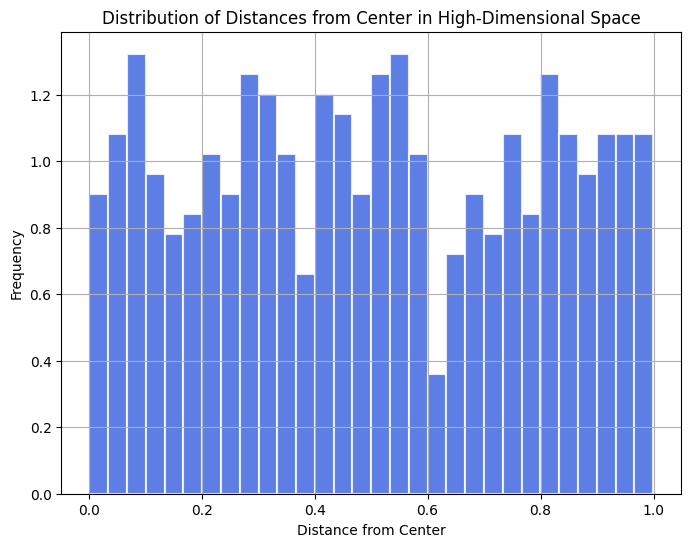

In [ ]:
# Генерация точек в высокомерном пространстве
np.random.seed(42)
n_points = 500
high_dim = 10
radius = 1.0

# Случайные точки внутри гиперсферы высокой размерности
points_high_dim = np.random.normal(size=(n_points, high_dim))
points_high_dim /= np.linalg.norm(points_high_dim, axis=1, keepdims=True)
points_high_dim *= np.random.uniform(0, radius, size=(n_points, 1))

# Расстояния от центра в высокомерном пространстве
distances_from_center = np.linalg.norm(points_high_dim, axis=1)

# Визуализация распределения расстояний в высокомерном пространстве
plt.figure(figsize=(8, 6))
plt.hist(
    distances_from_center,
    bins=30,
    color='royalblue',
    alpha=0.85,
    edgecolor='white',
    linewidth=1.5,
    density=True
)
plt.title("Distribution of Distances from Center in High-Dimensional Space")
plt.xlabel("Distance from Center")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

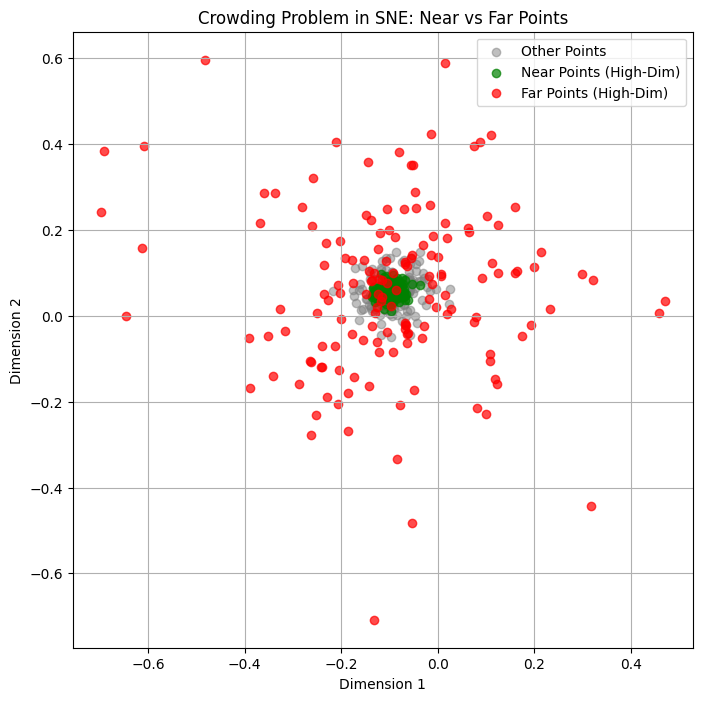

In [ ]:
sne_projection = sne(points_high_dim, n_components=2, perplexity=30, learning_rate=0.1, n_iter=500)
# Выделение близких и дальних точек для демонстрации проблемы скученности
threshold_near = 0.3 * radius
threshold_far = 0.7 * radius
near_points_mask = distances_from_center < threshold_near
far_points_mask = distances_from_center > threshold_far
plt.figure(figsize=(8, 8))
plt.scatter(sne_projection[~near_points_mask & ~far_points_mask][:, 0],
            sne_projection[~near_points_mask & ~far_points_mask][:, 1],
            color='gray', alpha=0.5, label="Other Points")
plt.scatter(sne_projection[near_points_mask][:, 0],
            sne_projection[near_points_mask][:, 1],
            color='green', alpha=0.7, label="Near Points (High-Dim)")
plt.scatter(sne_projection[far_points_mask][:, 0],
            sne_projection[far_points_mask][:, 1],
            color='red', alpha=0.7, label="Far Points (High-Dim)")
plt.title("Crowding Problem in SNE: Near vs Far Points")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.grid(True)
# ax.set_ylim(0, max(probs)+0.15)
ax.set_xlim(-0.45, 0.45)
plt.show()

#### t-SNE

В пространстве $y_1, \ldots y_n$ выбор соседа $y_j$ для $y_i$ определяем пропорционально $t_1$-распределению Стьюдента:
$$
q_{ij} = \dfrac{(1 + \|y_i - y_j\|^2)^{-1}}{\sum_{i\neq j}(1 + \|y_i - y_j\|^2)^{-1}}
$$
Соответствующий градиент по $y_i$
$$
\dfrac{\partial\mathcal{L}}{\partial y_i} = 4\sum_{i=1}^n\dfrac{(p_{ij} - q_{ij})(y_i - y_j)}{1 + \|y_i - y_j\|^2}
$$



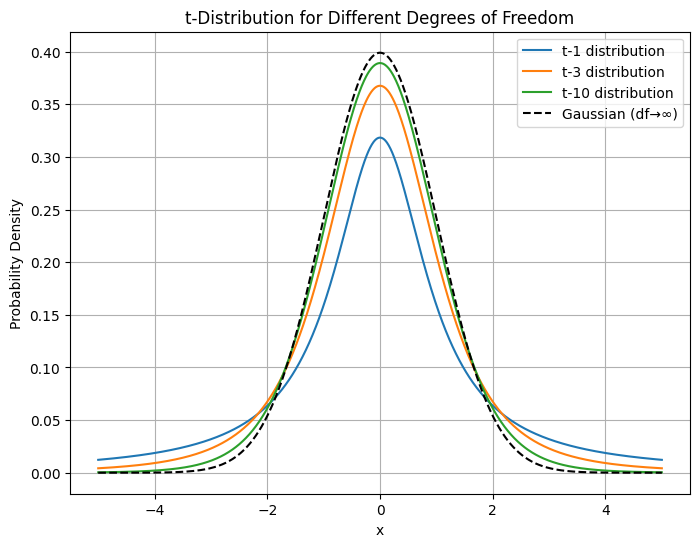

In [ ]:
from scipy.stats import t, norm


x = np.linspace(-5, 5, 1000)
t_values = [1, 3, 10]
plt.figure(figsize=(8, 6))
for df in t_values:
    plt.plot(x, t.pdf(x, df), label=f"t-{df} distribution")
plt.plot(x, norm.pdf(x, 0, 1), 'k--', label="Gaussian (df→∞)")
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.title("t-Distribution for Different Degrees of Freedom")
plt.legend()
plt.grid()
plt.show()

In [ ]:
from sklearn.manifold import TSNE

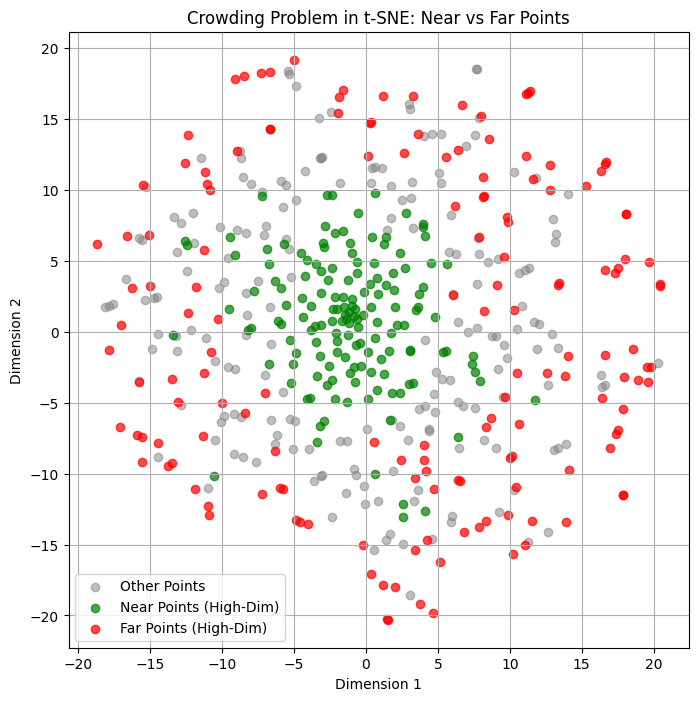

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_projection = tsne.fit_transform(points_high_dim)


threshold_near = 0.3 * radius
threshold_far = 0.7 * radius
near_points_mask = distances_from_center < threshold_near
far_points_mask = distances_from_center > threshold_far
plt.figure(figsize=(8, 8))
plt.scatter(tsne_projection[~near_points_mask & ~far_points_mask][:, 0],
            tsne_projection[~near_points_mask & ~far_points_mask][:, 1],
            color='gray', alpha=0.5, label="Other Points")
plt.scatter(tsne_projection[near_points_mask][:, 0],
            tsne_projection[near_points_mask][:, 1],
            color='green', alpha=0.7, label="Near Points (High-Dim)")
plt.scatter(tsne_projection[far_points_mask][:, 0],
            tsne_projection[far_points_mask][:, 1],
            color='red', alpha=0.7, label="Far Points (High-Dim)")
plt.title("Crowding Problem in t-SNE: Near vs Far Points")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.grid(True)
plt.show()


#### t-SNE + MNIST

t-SNE страдает от проклятия размерности -- вычислительная сложность $\mathcal{O}(n^2d)$, поэтому рекомендуется вначале снизить размерность с помощью PCA

In [ ]:
%%time
pca = PCA(n_components=30)
pca_X = pca.fit_transform(X)
pca.explained_variance_ratio_.sum()

CPU times: user 3.85 s, sys: 8.05 ms, total: 3.85 s
Wall time: 1.98 s


np.float64(0.7316323070665494)

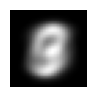

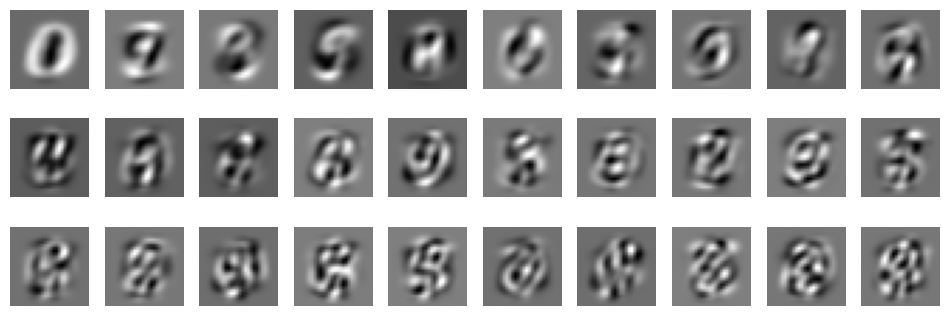

In [ ]:
plt.figure(figsize=(1, 1))
plt.imshow(pca.mean_.reshape((28, 28)), cmap='gray')
plt.axis('off')
plt.show()

plt.figure(figsize=(12, 4))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.imshow(pca.components_[i].reshape((28, 28)), cmap='gray')
    plt.axis('off')

In [ ]:
%%time
tsne = TSNE(n_components=2, perplexity=40)
tsne_X = tsne.fit_transform(pca_X)

CPU times: user 22min 50s, sys: 1.55 s, total: 22min 51s
Wall time: 22min 55s


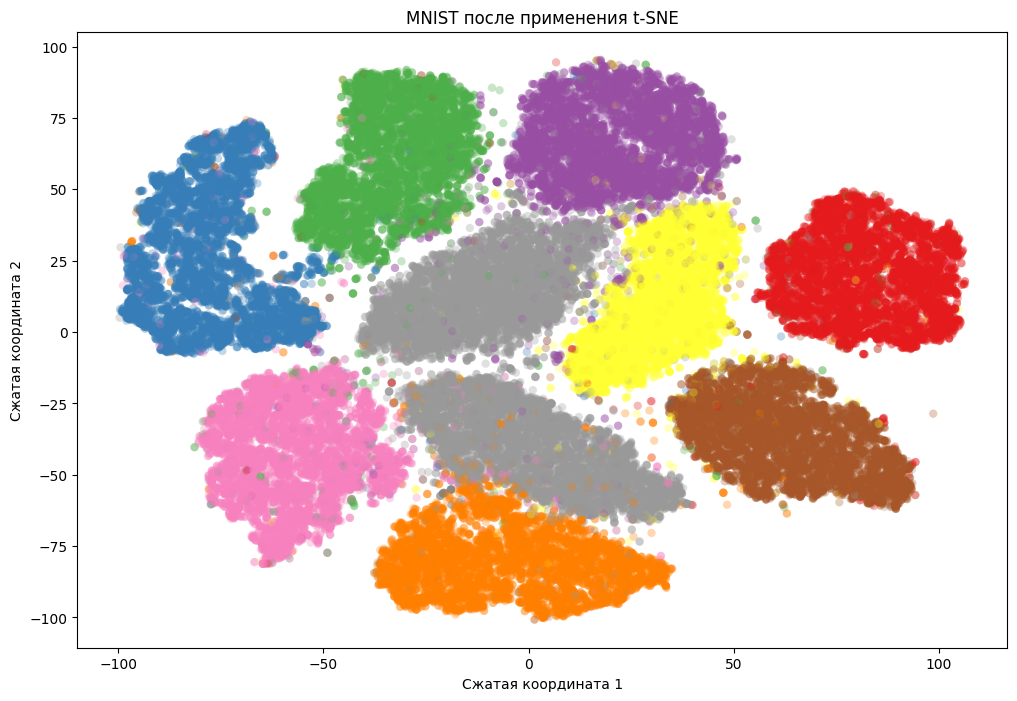

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(tsne_X[:, 0], tsne_X[:, 1], c=y, linewidths=0, cmap='Set1', alpha=0.3)
plt.xlabel('Сжатая координата 1')
plt.ylabel('Сжатая координата 2')
plt.title('MNIST после применения t-SNE')
plt.show()

In [ ]:
n_clusters = 10  # Since MNIST has 10 digits (0-9)
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(tsne_X)

def map_clusters_to_labels(y_true, y_pred, n_clusters):
    mapping = {}
    for cluster in range(n_clusters):
        mask = y_pred == cluster
        labels, counts = np.unique(y_true[mask], return_counts=True)
        mapping[cluster] = labels[np.argmax(counts)]
    return mapping

cluster_to_label = map_clusters_to_labels(y, kmeans.labels_, n_clusters)

y_pred_labels = np.array([cluster_to_label[cluster] for cluster in kmeans.labels_])

print("\nClassification Report:")
print(classification_report(y, y_pred_labels))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6903
           1       0.94      0.88      0.91      7877
           2       0.86      0.88      0.87      6990
           3       0.96      0.95      0.95      7141
           4       0.90      0.95      0.93      6824
           5       0.85      0.87      0.86      6313
           6       0.93      0.99      0.96      6876
           7       0.97      0.97      0.97      7293
           8       0.91      0.85      0.88      6825
           9       0.85      0.82      0.83      6958

    accuracy                           0.92     70000
   macro avg       0.91      0.92      0.91     70000
weighted avg       0.92      0.92      0.92     70000



In [ ]:
%%time
ri_score = rand_score(y, kmeans.labels_)
ari_score = adjusted_rand_score(y, kmeans.labels_)
print(f"Rand Index (RI): {ri_score:.4f}")
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")

Rand Index (RI): 0.9694
Adjusted Rand Index (ARI): 0.8305
CPU times: user 22.8 ms, sys: 0 ns, total: 22.8 ms
Wall time: 22.8 ms


In [ ]:
%%time
silhouette_avg = silhouette_score(tsne_X, kmeans.labels_)
db_avg = davies_bouldin_score(tsne_X, kmeans.labels_)

print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Davies Bouldin Score: {db_avg:.4f}")

Silhouette Score: 0.4439
Davies Bouldin Score: 0.7458
CPU times: user 1min 42s, sys: 11.3 s, total: 1min 53s
Wall time: 1min 22s


### Cсылки


1. Визуализация работы [K-means](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/)
2. Визуализация [DBSCAN](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/).
3. [Иерархическая кластеризация](https://neerc.ifmo.ru/wiki/index.php?title=%D0%98%D0%B5%D1%80%D0%B0%D1%80%D1%85%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F)
4. [DBSCAN vs OPTICS](https://www.atlantbh.com/clustering-algorithms-dbscan-vs-optics/)
    * [OPTICS demo](https://scikit-learn.org/stable/auto_examples/cluster/plot_optics.html#sphx-glr-auto-examples-cluster-plot-optics-py)
5. HDBSCAN
    * [How HDBSCAN Works](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html)
    * [HDBSCAN demo](https://scikit-learn.org/stable/auto_examples/cluster/plot_hdbscan.html#sphx-glr-auto-examples-cluster-plot-hdbscan-py)
6. [Метрики качества](https://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%B2_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B5_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8)
7. t-SNE
    * t-Distributed Stochastic Neighbor Embedding (t-SNE) -- [Оффициальная страница автора](https://lvdmaaten.github.io/tsne/)

    * Реализация в sklearn: [sklearn.manifold.TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)




